## Импорт данных

In [ ]:
import pandas as pd # Библиотека Pandas для работы с табличными данными
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
from google.colab import files # чтобы загружать файлы в облако через проводник
uploaded = files.upload() #просто запускаем и выбираем файл  API токена в проводнике

#↓ строка которая активирует наш API токен
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!kaggle competitions download -c urfuaieng2022reg2

 97% 41.0M/42.1M [00:00<00:00, 105MB/s] 
100% 42.1M/42.1M [00:00<00:00, 86.6MB/s]


In [ ]:
!unzip urfuaieng2022reg2.zip

Archive:  urfuaieng2022reg2.zip
  inflating: Submission_reg.csv      
  inflating: Test_Who.csv            
  inflating: Train_Target_reg.csv    
  inflating: Train_Who.csv           
  inflating: assessments.csv         
  inflating: courses.csv             
  inflating: studentAssessment.csv   
  inflating: studentInfo.csv         
  inflating: studentRegistration.csv  
  inflating: studentVle.csv          
  inflating: vle.csv                 


В своей работе я вдохновлялся ноутбуком данного [автора](https://www.kaggle.com/code/sashatarakanova/student-failure-modelling-with-a-messy-dataset/notebook).  
В частности подсмотрел несколько идей по генерации признаков и общей специфики таблиц

In [ ]:
def compareCols(df1, df2):
    '''
    Проверьте, какие столбцы являются общими для двух фреймов данных,
    и подсчитайте значения df1, присутствующие и отсутствующие в df2 (в общих столбцах).
    '''

    # Показать общие столбцы между фреймами данных
    # (a) Составьте списки столбцов для каждого фрейма данных
    df1Columns = df1.columns.values.tolist()
    df2Columns = df2.columns.values.tolist()

    # (b) Найдите одинаковые имена столбцов
    diffDict = set(df1Columns) & set(df2Columns)

    print('Общие колонки : ', diffDict, '\n')

    # (c) Составьте список из словаря
    diffList = list(diffDict)
    # (d) Убедитесь, что если значения в
    # каждый общий столбец совпадает в
    # двух фреймах данных
    for col in diffList:
        x = df1[col].isin(df2[col]).value_counts()
        print('Проверяем, присутствуют ли значения в обоих фреймах данных:')
        print(x, '\n')



In [ ]:
def findDiffValues(df1, df2, col):
    '''
    Найти все значения df1.col, отсутствующие в df2.col
    '''
    # Вытащите все уникальные значения col
    df1_IDs = df1[col].unique()
    df2_IDs = df2[col].unique()

    # Сравните два списка
    # (a) Найдите, какие значения отличаются
    diff = set(df1_IDs).difference(set(df2_IDs))
    # (b) осчитайте, сколько разных
    numberDiff = len(diff)

    print("Значения из df1 не в df2: " + str(diff))
    print("Количество пропущенных значений: " + str(numberDiff))

In [ ]:
def printDiffValues(df1, df2, col):
    '''
    Показать все значения df1.col, отсутствующие в df2.col
    '''
    # Вытащить все уникальные значения col
    df1_IDs = df1[col].unique()
    df2_IDs = df2[col].unique()

    # Сравните два списка
    # (a) Найдите, какие значения отличаются
    diff = set(df1_IDs).difference(set(df2_IDs))

    # Показать информацию обо всех значениях df1.col, отсутствующих в df2.col
    # (a) Составьте список недостающих значений
    missingList = list(diff)
    # (b) Найдите эти идентификаторы в df2
    missingDf = df1[df1[col].isin(missingList)]

    return missingDf

In [ ]:
def cross_validation (X, y, model, scoring, cv_rule):
    scores = cross_validate(model,X, y,
                      scoring=scoring, cv=cv_rule )
    print('Ошибка на кросс-валидации')
    DF_poly = pd.DataFrame(scores)
    display(DF_poly)
    print('\n')
    print(DF_poly.mean()[2:])

In [ ]:
def feature_importance_plotter(model, features_names):
    feature_importance = model.feature_importances_

    sorted = np.argsort(feature_importance)

    ypos = np.arange(len(features_names))

    fig= plt.figure(figsize=(14,8))
    plt.barh(ypos, feature_importance[sorted])
    plt.xlim([0,1])
    plt.ylabel('Параметры')
    plt.xlabel('Значимость')
    plt.yticks(ypos,features_names[sorted] );

In [ ]:
# данные которые "все"
ass = pd.read_csv('/content/assessments.csv')
courses = pd.read_csv('/content/courses.csv')
results = pd.read_csv('/content/studentAssessment.csv')
info = pd.read_csv('/content/studentInfo.csv')
reg = pd.read_csv('/content/studentRegistration.csv')
vle = pd.read_csv('/content/studentVle.csv')
materials = pd.read_csv('/content/vle.csv')

In [ ]:
Train_Who = pd.read_csv('/content/Train_Who.csv')
Train_Target_reg = pd.read_csv('/content/Train_Target_reg.csv')
Test_Who = pd.read_csv('/content/Test_Who.csv')

## Assessments info (информация об оценках)

1. **code_module** – идентификационный код модуля, которому принадлежит оценка.
2. **code_presentation** - идентификационный код презентации, к которой относится оценка.
3. **id_assessment** – идентификационный номер оценки.
4. **assessment_type** – вид оценки. Существует три типа оценок: оцениваемая репетитором (TMA), компьютерная оцениваемая оценка (CMA) и итоговый экзамен (Exam).
5. **date** – информация об окончательной дате сдачи оценки, рассчитанная как количество дней с момента начала модуля-презентации. Дата начала презентации имеет номер 0 (ноль).
6. **weight** - вес оценки в %. Обычно Экзамены обрабатываются отдельно и имеют вес 100%; сумма всех остальных оценок равна 100%.

In [ ]:
ass.info() # информация о данных в датафрейме

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 206 entries, 0 to 205
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   code_module        206 non-null    object 
 1   code_presentation  206 non-null    object 
 2   id_assessment      206 non-null    int64  
 3   assessment_type    206 non-null    object 
 4   date               195 non-null    float64
 5   weight             206 non-null    float64
dtypes: float64(2), int64(1), object(3)
memory usage: 9.8+ KB


In [ ]:
ass.head() # делаем срез данных для наглядного представления

,code_module,code_presentation,id_assessment,assessment_type,date,weight
0,AAA,2013J,1752,TMA,19.0,10.0
1,AAA,2013J,1753,TMA,54.0,20.0
2,AAA,2013J,1754,TMA,117.0,20.0
3,AAA,2013J,1755,TMA,166.0,20.0
4,AAA,2013J,1756,TMA,215.0,30.0


In [ ]:
ass.isnull().sum() * 100 / len(ass) # процент пропущенных значений

code_module          0.000000
code_presentation    0.000000
id_assessment        0.000000
assessment_type      0.000000
date                 5.339806
weight               0.000000
dtype: float64

Смотрим сколько у нас уникальных значений модуля курса, презентаций по модулю, типов оценки, "весов" или коэффицентов значимости оценки

In [ ]:
ass.nunique()

code_module            7
code_presentation      4
id_assessment        206
assessment_type        3
date                  74
weight                24
dtype: int64

In [ ]:
ass[ass.duplicated()] # дубликатов нет

,code_module,code_presentation,id_assessment,assessment_type,date,weight


В кратком описании проекта говорится, что обычно экзамены имеют вес 100, а сумма всех других оценок равна 100. Это означает, что модуль с одним экзаменом будет иметь вес 100, а модуль с одним экзаменом и несколькими оценками будет иметь вес 200. Давайте проверим, так ли это в представленной таблице.

Заметим, что модуль "ССС" имеет вес оценки = 300

In [ ]:
ass.groupby(['code_module','code_presentation']).agg(total_weight = ('weight',sum))

total_weight
code_module code_presentation              
AAA         2013J                     200.0
            2014J                     200.0
BBB         2013B                     200.0
            2013J                     200.0
            2014B                     200.0
            2014J                     200.0
CCC         2014B                     300.0
            2014J                     300.0
DDD         2013B                     200.0
            2013J                     200.0
            2014B                     200.0
            2014J                     200.0
EEE         2013J                     200.0
            2014B                     200.0
            2014J                     200.0
FFF         2013B                     200.0
            2013J                     200.0
            2014B                     200.0
            2014J                     200.0
GGG         2013J                     100.0
            2014B                     100.0
            2014J                     100.0

In [ ]:
# Посмотрим из чего она состоит
ass[ass['assessment_type'] == 'Exam']\
.groupby(['code_module','code_presentation', 'assessment_type'])\
.agg(total_weight = ('weight',sum))

total_weight
code_module code_presentation assessment_type              
AAA         2013J             Exam                    100.0
            2014J             Exam                    100.0
BBB         2013B             Exam                    100.0
            2013J             Exam                    100.0
            2014B             Exam                    100.0
            2014J             Exam                    100.0
CCC         2014B             Exam                    200.0
            2014J             Exam                    200.0
DDD         2013B             Exam                    100.0
            2013J             Exam                    100.0
            2014B             Exam                    100.0
            2014J             Exam                    100.0
EEE         2013J             Exam                    100.0
            2014B             Exam                    100.0
            2014J             Exam                    100.0
FFF         2013B             Exam                    100.0
            2013J             Exam                    100.0
            2014B             Exam                    100.0
            2014J             Exam                    100.0
GGG         2013J             Exam                    100.0
            2014B             Exam                    100.0
            2014J             Exam                    100.0

In [ ]:
# Посмотрим сколько оценок за экзамен можно получить в отдельном модуле
ass[ass['assessment_type'] == 'Exam'][['code_module', 'code_presentation', 'id_assessment']]\
.groupby(['code_module', 'code_presentation'])\
.count()

id_assessment
code_module code_presentation               
AAA         2013J                          1
            2014J                          1
BBB         2013B                          1
            2013J                          1
            2014B                          1
            2014J                          1
CCC         2014B                          2
            2014J                          2
DDD         2013B                          1
            2013J                          1
            2014B                          1
            2014J                          1
EEE         2013J                          1
            2014B                          1
            2014J                          1
FFF         2013B                          1
            2013J                          1
            2014B                          1
            2014J                          1
GGG         2013J                          1
            2014B                          1
            2014J                          1

In [ ]:
# Сумма весов всех заданий курсовой работы за презентацию модуля
ass[ass['assessment_type'] != 'Exam']\
.groupby(['code_module', 'code_presentation'])\
.agg(total_weight = ('weight',sum))

total_weight
code_module code_presentation              
AAA         2013J                     100.0
            2014J                     100.0
BBB         2013B                     100.0
            2013J                     100.0
            2014B                     100.0
            2014J                     100.0
CCC         2014B                     100.0
            2014J                     100.0
DDD         2013B                     100.0
            2013J                     100.0
            2014B                     100.0
            2014J                     100.0
EEE         2013J                     100.0
            2014B                     100.0
            2014J                     100.0
FFF         2013B                     100.0
            2013J                     100.0
            2014B                     100.0
            2014J                     100.0
GGG         2013J                       0.0
            2014B                       0.0
            2014J                       0.0

In [ ]:
# В модуле GGG задания CMA и TMA имеют вес = 0
ass[ass['code_module'] == 'GGG']\
.groupby(['code_module','code_presentation', 'assessment_type'])\
.agg(weight_by_type = ('weight', sum))

weight_by_type
code_module code_presentation assessment_type                
GGG         2013J             CMA                         0.0
                              Exam                      100.0
                              TMA                         0.0
            2014B             CMA                         0.0
                              Exam                      100.0
                              TMA                         0.0
            2014J             CMA                         0.0
                              Exam                      100.0
                              TMA                         0.0

In [ ]:
# Посчитаем сколько таких записей с весами CMA = 0 в других модулях
ass[(ass['assessment_type'] == 'CMA') & (ass['weight'] == 0) & (ass['code_module'] != 'GGG')]['weight'].count()

28

In [ ]:
# Посчитаем сколько таких записей с весами TMA = 0 в других модулях
ass[(ass['assessment_type'] == 'TMA') & (ass['weight'] == 0) & (ass['code_module'] != 'GGG')]['weight'].count()

1

In [ ]:
# Присвоим новые веса оценкам модуля GGG
ass.loc[(ass.code_module=='GGG') & (ass.assessment_type=='TMA'),'weight'] = (100/3)
ass.loc[(ass.code_module=='GGG') & (ass.assessment_type=='CMA'),'weight'] = (0)

In [ ]:
# Проверяем, что сумма TMA теперь равна 100
ass[ass['code_module'] == 'GGG']\
.groupby(['code_module','code_presentation', 'assessment_type'])\
.agg(weight_by_type = ('weight', sum))

weight_by_type
code_module code_presentation assessment_type                
GGG         2013J             CMA                         0.0
                              Exam                      100.0
                              TMA                       100.0
            2014B             CMA                         0.0
                              Exam                      100.0
                              TMA                       100.0
            2014J             CMA                         0.0
                              Exam                      100.0
                              TMA                       100.0

## Assessments results (результаты оценки)

1. **id_assessment** – идентификационный номер оценки.
2. **id_student** –уникальный идентификационный номер студента.
3. **date_submitted** – дата представления студентом, измеряемая как количество дней с начала презентации модуля.
4. **is_banked** – флаг состояния, указывающий, что результат оценки был перенесен из предыдущей презентации.

In [ ]:
results.info() # информация о данных

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 173912 entries, 0 to 173911
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype
---  ------          --------------   -----
 0   id_assessment   173912 non-null  int64
 1   id_student      173912 non-null  int64
 2   date_submitted  173912 non-null  int64
 3   is_banked       173912 non-null  int64
dtypes: int64(4)
memory usage: 5.3 MB


In [ ]:
results.head()  # срез данных для наглядного представления

,id_assessment,id_student,date_submitted,is_banked
0,1752,11391,18,0
1,1752,28400,22,0
2,1752,31604,17,0
3,1752,32885,26,0
4,1752,38053,19,0


In [ ]:
results.isnull().sum() * 100 / len(results) # пропусков нет

id_assessment     0.0
id_student        0.0
date_submitted    0.0
is_banked         0.0
dtype: float64

In [ ]:
results[results.duplicated()] # дубликатов тоже

,id_assessment,id_student,date_submitted,is_banked


### Сравнение наполнения датафреймов

Сравним фреймы `Assessments info` и `Assessments results`

In [ ]:
compareCols(ass, results)

Общие колонки :  {'id_assessment'} 

Проверяем, присутствуют ли значения в обоих фреймах данных:
True     188
False     18
Name: id_assessment, dtype: int64 



18 `id_assessment`не хватает

уточним какие:

In [ ]:
findDiffValues(ass, results, 'id_assessment')

Значения из df1 не в df2: {30723, 1763, 34885, 15014, 37444, 14990, 30713, 37424, 15025, 34898, 37434, 40087, 34872, 40088, 15002, 1757, 30718, 34911}
Количество пропущенных значений: 18


отобразим, чего нет

In [ ]:
printDiffValues(ass, results, 'id_assessment')

,code_module,code_presentation,id_assessment,assessment_type,date,weight
5,AAA,2013J,1757,Exam,NaN,100.0
11,AAA,2014J,1763,Exam,NaN,100.0
23,BBB,2013B,14990,Exam,NaN,100.0
35,BBB,2013J,15002,Exam,NaN,100.0
47,BBB,2014B,15014,Exam,NaN,100.0
53,BBB,2014J,15025,Exam,NaN,100.0
63,CCC,2014B,40087,Exam,NaN,100.0
73,CCC,2014J,40088,Exam,NaN,100.0
113,EEE,2013J,30713,Exam,235.0,100.0
118,EEE,2014B,30718,Exam,228.0,100.0


In [ ]:
missingList = [30723, 1763, 34885, 15014, 37444, 14990, 30713, 37424, 15025, 34898, 37434, 40087, 34872, 40088, 15002, 1757, 30718, 34911]

# Получаем все строки, где вес оценки == 100
weight100 = ass[ass['weight'] == 100]
# Получаем все уникальные идентификаторы оценки
weight100List = weight100['id_assessment'].unique()

# Сравниваем этот список со списком всех идентификаторов оценок (таблица ass), отсутствующих в таблице result
compare = set(weight100List).difference(set(missingList))
numberCompare = len(compare)

print(compare)
numberCompare

{24290, 25354, 24299, 25361, 25368, 25340}


6

In [ ]:
matchList = [24290, 25354, 24299, 25361, 25368, 25340]
# Ищем эти id в таблице ass
matchDf = ass[ass['id_assessment'].isin(matchList)]

matchDf

,code_module,code_presentation,id_assessment,assessment_type,date,weight
62,CCC,2014B,24290,Exam,NaN,100.0
72,CCC,2014J,24299,Exam,NaN,100.0
87,DDD,2013B,25340,Exam,240.0,100.0
94,DDD,2013J,25354,Exam,261.0,100.0
101,DDD,2014B,25361,Exam,241.0,100.0
108,DDD,2014J,25368,Exam,NaN,100.0


## Courses info (информация о курсах)

1. **code_module** – кодовое имя модуля, которое служит идентификатором.
2. **code_presentation** – кодовое название презентации. Он состоит из года и «B» для презентации, начинающейся в феврале, и «J» для презентации, начинающейся в октябре.
3. **module_presentation_length** - длина модуля-презентации в днях.

In [ ]:
courses.info() # информация о данных

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22 entries, 0 to 21
Data columns (total 3 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   code_module                 22 non-null     object
 1   code_presentation           22 non-null     object
 2   module_presentation_length  22 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 656.0+ bytes


In [ ]:
courses.head() # наглядный срез таблицы

,code_module,code_presentation,module_presentation_length
0,AAA,2013J,268
1,AAA,2014J,269
2,BBB,2013J,268
3,BBB,2014J,262
4,BBB,2013B,240


In [ ]:
courses.isnull().sum() * 100 / len(courses) # пропущенных значений нет

code_module                   0.0
code_presentation             0.0
module_presentation_length    0.0
dtype: float64

In [ ]:
courses[courses.duplicated()] # пропусков тоже

,code_module,code_presentation,module_presentation_length


In [ ]:
courses.nunique() # уникальные значения

code_module                   7
code_presentation             4
module_presentation_length    7
dtype: int64

## Student registration (регистрация студентов)

1. **code_module** – идентификационный код модуля.
2. **code_presentation** - идентификационный код презентации.
3. **id_student** – уникальный идентификационный номер студента.
4. **date_registration** – дата регистрации студента на презентацию модуля, это количество дней, измеренное относительно начала презентации модуля (например, отрицательное значение -30 означает, что студент зарегистрировался на презентацию модуля за 30 дней до ее начала).

In [ ]:
reg.info() # информация о данных в датафрейме

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32593 entries, 0 to 32592
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   code_module        32593 non-null  object 
 1   code_presentation  32593 non-null  object 
 2   id_student         32593 non-null  int64  
 3   date_registration  32548 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 1018.7+ KB


In [ ]:
reg.head() # Метод .head() - первые 5 строк

,code_module,code_presentation,id_student,date_registration
0,AAA,2013J,11391,-159.0
1,AAA,2013J,28400,-53.0
2,AAA,2013J,30268,-92.0
3,AAA,2013J,31604,-52.0
4,AAA,2013J,32885,-176.0


In [ ]:
reg.isnull().sum() * 100 / len(reg)

code_module          0.000000
code_presentation    0.000000
id_student           0.000000
date_registration    0.138066
dtype: float64

In [ ]:
reg[reg.duplicated()]

,code_module,code_presentation,id_student,date_registration


Проверяем, все ли id студентов, записанные в таблице "регистрации" - reg, записаны в таблице result

In [ ]:
compareCols(reg, results)

Общие колонки :  {'id_student'} 

Проверяем, присутствуют ли значения в обоих фреймах данных:
True     26746
False     5847
Name: id_student, dtype: int64 



Есть ли студенты из таблицы "info", отсутствующие в таблице "result"?

In [ ]:
compareCols(info, results)

Общие колонки :  {'id_student'} 

Проверяем, присутствуют ли значения в обоих фреймах данных:
True     26746
False     5847
Name: id_student, dtype: int64 



In [ ]:
# Это одни и те же студенты?
df1_IDs = reg['id_student'].unique()
df2_IDs = info['id_student'].unique()

diff = set(df1_IDs).difference(set(df2_IDs))

numberDiff = len(diff)

numberDiff

0

In [ ]:
# Видимо так оно и есть
compareCols(reg, info)

Общие колонки :  {'code_module', 'code_presentation', 'id_student'} 

Проверяем, присутствуют ли значения в обоих фреймах данных:
True    32593
Name: code_module, dtype: int64 

Проверяем, присутствуют ли значения в обоих фреймах данных:
True    32593
Name: code_presentation, dtype: int64 

Проверяем, присутствуют ли значения в обоих фреймах данных:
True    32593
Name: id_student, dtype: int64 



## VLE resources

1. **id_site** - идентификационный номер материала.
2. **code_module** – идентификационный код модуля.
3. **code_presentation** - идентификационный код презентации.
4. **activity_type** – роль, связанная с материалом модуля.
5. **week_from** – неделя, с которой планируется использовать материал.
6. **week_to** – неделя, до которой планируется использовать материал.

In [ ]:
materials.info() # информация о данных в датафрейме

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6364 entries, 0 to 6363
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id_site            6364 non-null   int64  
 1   code_module        6364 non-null   object 
 2   code_presentation  6364 non-null   object 
 3   activity_type      6364 non-null   object 
 4   week_from          1121 non-null   float64
 5   week_to            1121 non-null   float64
dtypes: float64(2), int64(1), object(3)
memory usage: 298.4+ KB


In [ ]:
materials.head() # наглядный срез данных таблицы

,id_site,code_module,code_presentation,activity_type,week_from,week_to
0,546943,AAA,2013J,resource,NaN,NaN
1,546712,AAA,2013J,oucontent,NaN,NaN
2,546998,AAA,2013J,resource,NaN,NaN
3,546888,AAA,2013J,url,NaN,NaN
4,547035,AAA,2013J,resource,NaN,NaN


Атрибуты week_from и week_to имеют огромный процент пропущенных значений

In [ ]:
materials.isnull().sum() * 100 / len(materials)

id_site               0.000000
code_module           0.000000
code_presentation     0.000000
activity_type         0.000000
week_from            82.385292
week_to              82.385292
dtype: float64

In [ ]:
materials[materials.duplicated()] # но дубликатов нет

,id_site,code_module,code_presentation,activity_type,week_from,week_to


## VLE Interactions

1. **code_module** – идентификационный код модуля.
2. **code_presentation** - идентификационный код представления модуля.
3. **id_student** – уникальный идентификационный номер студента.
4. **id_site** - идентификационный номер материала VLE.
5. **date** – дата взаимодействия студента с материалом измеряется как количество дней с начала модуля-презентации.
6. **sum_click** – сколько раз учащийся взаимодействовал с материалом в этот день.

Таблица содержит информацию о взаимодействии каждого студента с материалами в VLE

In [ ]:
vle.info() # информация о данных

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10655280 entries, 0 to 10655279
Data columns (total 6 columns):
 #   Column             Dtype 
---  ------             ----- 
 0   code_module        object
 1   code_presentation  object
 2   id_student         int64 
 3   id_site            int64 
 4   date               int64 
 5   sum_click          int64 
dtypes: int64(4), object(2)
memory usage: 487.8+ MB


In [ ]:
vle.head() # наглядный срез данных таблицы

,code_module,code_presentation,id_student,id_site,date,sum_click
0,AAA,2013J,28400,546652,-10,4
1,AAA,2013J,28400,546652,-10,1
2,AAA,2013J,28400,546652,-10,1
3,AAA,2013J,28400,546614,-10,11
4,AAA,2013J,28400,546714,-10,1


In [ ]:
vle.isnull().sum() * 100 / len(vle) # пропусков нет

code_module          0.0
code_presentation    0.0
id_student           0.0
id_site              0.0
date                 0.0
sum_click            0.0
dtype: float64

In [ ]:
vle.duplicated().sum() # поиск дубликатов строк

787170

In [ ]:
vle[vle.duplicated()].head()

,code_module,code_presentation,id_student,id_site,date,sum_click
2,AAA,2013J,28400,546652,-10,1
63,AAA,2013J,45462,546652,-10,1
180,AAA,2013J,77367,546652,-10,4
193,AAA,2013J,94961,546652,-10,2
442,AAA,2013J,248270,546652,-10,4


Дублирование в данном случае вполне допустимо, поскольку система, скорее всего, регистрирует клики в разные моменты одного и того же дня, что приводит к появлению дубликатов

## Student information

1. **code_module** – идентификационный код модуля, на котором зарегистрирован студент.
2. **code_presentation** - идентификационный код презентации, во время которой студент регистрируется на модуле.
3. **id_student** – уникальный идентификационный номер студента.
4. **gender** – пол ученика.
5. **region** – определяет географический регион, в котором студент проживал во время прохождения модуля-презентации.
6. **highest_education** – самый высокий уровень образования студента при поступлении на модульную презентацию.
7. **imd_band** – задает диапазон [Index of Multiple Depravation](https://en.wikipedia.org/wiki/Multiple_deprivation_index#:~:text=Indices%20of%20multiple%20deprivation%20(IMD,a%20single%20score%20of%20deprivation.) места, где студент проживал во время модуля-презентации. (насколько бедный район, короче)
8. **age_band** – диапазон студенческого возраста.
9. **num_of_prev_attempts** – количество раз, когда учащийся пытался пройти этот модуль.
10. **studied_credits** – общее количество кредитов по модулям, которые студент изучает в настоящее время.
11. **disability** – указывает, признан ли студент инвалидом.

In [ ]:
info.info() # информация о данных

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32593 entries, 0 to 32592
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   code_module           32593 non-null  object
 1   code_presentation     32593 non-null  object
 2   id_student            32593 non-null  int64 
 3   gender                32593 non-null  object
 4   region                32593 non-null  object
 5   highest_education     32593 non-null  object
 6   imd_band              31482 non-null  object
 7   age_band              32593 non-null  object
 8   num_of_prev_attempts  32593 non-null  int64 
 9   studied_credits       32593 non-null  int64 
 10  disability            32593 non-null  object
dtypes: int64(3), object(8)
memory usage: 2.7+ MB


In [ ]:
info.head()  # наглядный срез данных таблицы

,code_module,code_presentation,id_student,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability
0,AAA,2013J,11391,M,East Anglian Region,HE Qualification,90-100%,55<=,0,240,N
1,AAA,2013J,28400,F,Scotland,HE Qualification,20-30%,35-55,0,60,N
2,AAA,2013J,30268,F,North Western Region,A Level or Equivalent,30-40%,35-55,0,60,Y
3,AAA,2013J,31604,F,South East Region,A Level or Equivalent,50-60%,35-55,0,60,N
4,AAA,2013J,32885,F,West Midlands Region,Lower Than A Level,50-60%,0-35,0,60,N


In [ ]:
info.isnull().sum() * 100 / len(info)

code_module             0.000000
code_presentation       0.000000
id_student              0.000000
gender                  0.000000
region                  0.000000
highest_education       0.000000
imd_band                3.408707
age_band                0.000000
num_of_prev_attempts    0.000000
studied_credits         0.000000
disability              0.000000
dtype: float64

Есть небольшой процент пропусков в атрибуте imd_band, его можно будет устранить

## Join tables

### Регистрация + Информация о курсах

In [ ]:
compareCols(reg, courses)

Общие колонки :  {'code_presentation', 'code_module'} 

Проверяем, присутствуют ли значения в обоих фреймах данных:
True    32593
Name: code_presentation, dtype: int64 

Проверяем, присутствуют ли значения в обоих фреймах данных:
True    32593
Name: code_module, dtype: int64 



In [ ]:
#                                     ↓ по каким колонкам буддем объединять     ↓ как
regCourses = pd.merge(reg, courses, on=['code_module', 'code_presentation'], how='inner')

regCourses.head()

,code_module,code_presentation,id_student,date_registration,module_presentation_length
0,AAA,2013J,11391,-159.0,268
1,AAA,2013J,28400,-53.0,268
2,AAA,2013J,30268,-92.0,268
3,AAA,2013J,31604,-52.0,268
4,AAA,2013J,32885,-176.0,268


### Регистрация + Информация о курсах + Инфа о студентах

In [ ]:
#                                     ↓ по каким колонкам буддем объединять                       ↓ как
regCoursesInfo = pd.merge(regCourses, info, on=['code_module', 'code_presentation', 'id_student'], how='inner')

regCoursesInfo.head()

,code_module,code_presentation,id_student,date_registration,module_presentation_length,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability
0,AAA,2013J,11391,-159.0,268,M,East Anglian Region,HE Qualification,90-100%,55<=,0,240,N
1,AAA,2013J,28400,-53.0,268,F,Scotland,HE Qualification,20-30%,35-55,0,60,N
2,AAA,2013J,30268,-92.0,268,F,North Western Region,A Level or Equivalent,30-40%,35-55,0,60,Y
3,AAA,2013J,31604,-52.0,268,F,South East Region,A Level or Equivalent,50-60%,35-55,0,60,N
4,AAA,2013J,32885,-176.0,268,F,West Midlands Region,Lower Than A Level,50-60%,0-35,0,60,N


 ### VLE + VLE Interactions

In [ ]:
compareCols(materials, vle)

Общие колонки :  {'code_presentation', 'code_module', 'id_site'} 

Проверяем, присутствуют ли значения в обоих фреймах данных:
True    6364
Name: code_presentation, dtype: int64 

Проверяем, присутствуют ли значения в обоих фреймах данных:
True    6364
Name: code_module, dtype: int64 

Проверяем, присутствуют ли значения в обоих фреймах данных:
True     6268
False      96
Name: id_site, dtype: int64 



В таблице "Материалы" в id_site есть 96 записей, которых нет в таблице VLE. И это, вероятно, означает, что эти ресурсы не были использованы ни одним студентом или что эти ресурсы не регистрировали активность. Поэтому мы можем объединить эти две таблицы через inner join, так как ресурсы, в которых нет активности ни одного ученика, предоставляют нулевую информацию. Колонки week_from и week_to можно отбросить, т.к пропусков более 82%. Отбросим дату, т.к она не дает дополнительной информации после группировки по модулю презентации для каждого студента.

In [ ]:
VLEmaterials = pd.merge(vle, materials, on=['code_module', 'code_presentation', 'id_site'], how='inner')

VLEmaterials.drop(columns=['week_from', 'week_to', 'date'], inplace=True)

VLEmaterials.head()

,code_module,code_presentation,id_student,id_site,sum_click,activity_type
0,AAA,2013J,28400,546652,4,forumng
1,AAA,2013J,28400,546652,1,forumng
2,AAA,2013J,28400,546652,1,forumng
3,AAA,2013J,28400,546652,8,forumng
4,AAA,2013J,30268,546652,3,forumng


### Assessment info + Assessment Results

In [ ]:
# merge with an inner join
assResults = pd.merge(ass, results, on=['id_assessment'], how='inner')
# Rearrange column names
assResults = assResults[['id_student', 'code_module', 'code_presentation', 'id_assessment', 'assessment_type', 'date', 'date_submitted', 'weight', 'is_banked']]

assResults.head()

,id_student,code_module,code_presentation,id_assessment,assessment_type,date,date_submitted,weight,is_banked
0,11391,AAA,2013J,1752,TMA,19.0,18,10.0,0
1,28400,AAA,2013J,1752,TMA,19.0,22,10.0,0
2,31604,AAA,2013J,1752,TMA,19.0,17,10.0,0
3,32885,AAA,2013J,1752,TMA,19.0,26,10.0,0
4,38053,AAA,2013J,1752,TMA,19.0,19,10.0,0


### Feature engineering

Сгенерируем признак - сумма кликов студента за одину презентацию модуля

In [ ]:
total_click_per_student = VLEmaterials\
.groupby(['code_module', 'code_presentation', 'id_student'])\
.agg(total_click = ("sum_click",sum))\
.reset_index()

total_click_per_student.head(7)

,code_module,code_presentation,id_student,total_click
0,AAA,2013J,11391,934
1,AAA,2013J,28400,1435
2,AAA,2013J,30268,281
3,AAA,2013J,31604,2158
4,AAA,2013J,32885,1034
5,AAA,2013J,38053,2445
6,AAA,2013J,45462,1492


In [ ]:
VLEmaterials\
.groupby(['code_module', 'code_presentation', 'id_student'])\
.agg(total_click = ("sum_click",sum))

total_click
code_module code_presentation id_student             
AAA         2013J             11391               934
                              28400              1435
                              30268               281
                              31604              2158
                              32885              1034
...                                               ...
GGG         2014J             2640965              41
                              2645731             893
                              2648187             312
                              2679821             275
                              2684003             616

[29228 rows x 1 columns]

Вычислим разницу между датами: дедлайн сдачи - фактическая дата сдачи.  
И сделаем временный признак "Задание сдано с опозданием" : True or False

In [ ]:
lateSubmission = assResults.assign(submission_days=assResults['date_submitted']-assResults['date'])

lateSubmission = lateSubmission.assign(late_submission=lateSubmission['submission_days'] > 0)

lateSubmission.head()

,id_student,code_module,code_presentation,id_assessment,assessment_type,date,date_submitted,weight,is_banked,submission_days,late_submission
0,11391,AAA,2013J,1752,TMA,19.0,18,10.0,0,-1.0,False
1,28400,AAA,2013J,1752,TMA,19.0,22,10.0,0,3.0,True
2,31604,AAA,2013J,1752,TMA,19.0,17,10.0,0,-2.0,False
3,32885,AAA,2013J,1752,TMA,19.0,26,10.0,0,7.0,True
4,38053,AAA,2013J,1752,TMA,19.0,19,10.0,0,0.0,False


Посчитаем сколько заданий с опозданием сдал студент по отдельному модулю и презентации

In [ ]:
total_late_per_student = lateSubmission\
.groupby(['id_student', 'code_module', 'code_presentation'])\
.agg(total_late_submission = ('late_submission', sum))\
.reset_index()

total_late_per_student.head()

,id_student,code_module,code_presentation,total_late_submission
0,6516,AAA,2014J,0
1,8462,DDD,2013J,1
2,8462,DDD,2014J,0
3,11391,AAA,2013J,0
4,23629,BBB,2013B,3


Теперь посчитаем сколько всего оценок получил студент по всем модулям и презентациям

In [ ]:
total_count_assessments = lateSubmission[['id_student', 'code_module', 'code_presentation', 'id_assessment']]\
.groupby(['id_student', 'code_module', 'code_presentation'])\
.size()\
.reset_index(name='total_assessments')

total_count_assessments.head()

,id_student,code_module,code_presentation,total_assessments
0,6516,AAA,2014J,5
1,8462,DDD,2013J,3
2,8462,DDD,2014J,4
3,11391,AAA,2013J,5
4,23629,BBB,2013B,4


Далее рассчитываем "индекс долгов по сдаче заданий", разделив кол-во опозданий по сдаче на общее кол-во оценок

In [ ]:
# Соединяем временные таблицы
late_rate_per_student = pd.merge(total_late_per_student, total_count_assessments, on=['id_student', 'code_module', 'code_presentation'], how='inner')

# Создаем наш признак
late_rate_per_student['late_rate'] = late_rate_per_student['total_late_submission'] / late_rate_per_student['total_assessments']

# Удаляем временные признаки
late_rate_per_student.drop(columns=['total_late_submission', 'total_assessments'], inplace=True)

late_rate_per_student

,id_student,code_module,code_presentation,late_rate
0,6516,AAA,2014J,0.000000
1,8462,DDD,2013J,0.333333
2,8462,DDD,2014J,0.000000
3,11391,AAA,2013J,0.000000
4,23629,BBB,2013B,0.750000
...,...,...,...,...
25838,2698257,AAA,2013J,0.400000
25839,2698535,CCC,2014B,0.750000
25840,2698535,EEE,2013J,0.250000
25841,2698577,BBB,2014J,0.000000


### Создание итогового датасета

Соединяем нашу сборную табилцу regCoursesInfo с табилцами, где сгенерированны новые признаки

In [ ]:
merged = pd.merge(regCoursesInfo, total_click_per_student, on=['id_student', 'code_module', 'code_presentation'], how='left')

merged.head()

,code_module,code_presentation,id_student,date_registration,module_presentation_length,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,total_click
0,AAA,2013J,11391,-159.0,268,M,East Anglian Region,HE Qualification,90-100%,55<=,0,240,N,934.0
1,AAA,2013J,28400,-53.0,268,F,Scotland,HE Qualification,20-30%,35-55,0,60,N,1435.0
2,AAA,2013J,30268,-92.0,268,F,North Western Region,A Level or Equivalent,30-40%,35-55,0,60,Y,281.0
3,AAA,2013J,31604,-52.0,268,F,South East Region,A Level or Equivalent,50-60%,35-55,0,60,N,2158.0
4,AAA,2013J,32885,-176.0,268,F,West Midlands Region,Lower Than A Level,50-60%,0-35,0,60,N,1034.0


In [ ]:
merged = pd.merge(merged, late_rate_per_student, on=['id_student', 'code_module', 'code_presentation'], how='left')

merged.head()

,code_module,code_presentation,id_student,date_registration,module_presentation_length,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,total_click,late_rate
0,AAA,2013J,11391,-159.0,268,M,East Anglian Region,HE Qualification,90-100%,55<=,0,240,N,934.0,0.0
1,AAA,2013J,28400,-53.0,268,F,Scotland,HE Qualification,20-30%,35-55,0,60,N,1435.0,0.4
2,AAA,2013J,30268,-92.0,268,F,North Western Region,A Level or Equivalent,30-40%,35-55,0,60,Y,281.0,NaN
3,AAA,2013J,31604,-52.0,268,F,South East Region,A Level or Equivalent,50-60%,35-55,0,60,N,2158.0,0.0
4,AAA,2013J,32885,-176.0,268,F,West Midlands Region,Lower Than A Level,50-60%,0-35,0,60,N,1034.0,1.0


Процент пропусков в итоговой таблице  
Далее будем подбирать стратегии их замене

In [ ]:
merged.isnull().sum() * 100 / len(merged)

code_module                    0.000000
code_presentation              0.000000
id_student                     0.000000
date_registration              0.138066
module_presentation_length     0.000000
gender                         0.000000
region                         0.000000
highest_education              0.000000
imd_band                       3.408707
age_band                       0.000000
num_of_prev_attempts           0.000000
studied_credits                0.000000
disability                     0.000000
total_click                   10.324303
late_rate                     20.709968
dtype: float64

## Выделение тренировочной и тестовой выборки

Список студентов, соответсвующих модулей и презентаций (разные студенты могут сдавать разные модули)

In [ ]:
Train_Who = pd.read_csv('/content/Train_Who.csv')
Train_Target_reg = pd.read_csv('/content/Train_Target_reg.csv')
Test_Who = pd.read_csv('/content/Test_Who.csv')

In [ ]:
Train_Who # тренировочные данные

,ID,id_student,code_module,code_presentation
0,0,464685,DDD,2014B
1,1,606593,DDD,2013J
2,2,1674799,CCC,2014J
3,3,195246,FFF,2014J
4,4,582080,FFF,2013J
...,...,...,...,...
26069,26069,588477,AAA,2014J
26070,26070,653826,BBB,2014J
26071,26071,126411,BBB,2013B
26072,26072,547448,DDD,2013J


In [ ]:
Train_Target_reg # целевой признак для тернировочных данных

,ID,weighted_score
0,0,64.9125
1,1,14.8625
2,2,61.4300
3,3,39.5000
4,4,9.2500
...,...,...
26069,26069,75.0000
26070,26070,75.0000
26071,26071,1.0000
26072,26072,86.0875


In [ ]:
Test_Who # тестовые данные

,ID,id_student,code_module,code_presentation
0,26074,2588655,DDD,2014J
1,26075,543628,CCC,2014B
2,26076,387276,BBB,2013B
3,26077,692219,CCC,2014J
4,26078,516212,BBB,2013J
...,...,...,...,...
6514,32588,230510,DDD,2013J
6515,32589,384026,DDD,2013B
6516,32590,2367155,AAA,2013J
6517,32591,501444,FFF,2014J


In [ ]:
Test_Who.shape

(6519, 4)

Добавим целевой признак из соревнования по классификации.  
Надеюсь так можно делать, т.к данные изначально из одного датасета

In [ ]:
Train_Target_clf = pd.read_csv('/content/Train_Target_clf.csv', index_col = 'ID')

Для тестовых данных добавим наше предсказание целевого признака из совернования по классификации

In [ ]:
Test_Target_clf = pd.read_csv('/content/xgboost_Submission.csv', index_col = 'ID')

Соединяем по Left Join тренировочные данные и получившуюся таблицу.

In [ ]:
#                                               ↓ по каким колонкам буддем объединять               ↓ как
Train = pd.merge(Train_Who, merged, on=['id_student', 'code_module', 'code_presentation'], how='left')
Train = pd.merge(Train, Train_Target_clf, on=['ID'], how='inner')
# Прячем "наш" ID в index фрейма
Train.index = Train.ID
# удаляем как столбец, ибо зачем
Train.drop(columns = ['ID'], inplace = True)
Train.head()

,id_student,code_module,code_presentation,date_registration,module_presentation_length,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,total_click,late_rate,final_result
ID,,,,,,,,,,,,,,,,
0,464685,DDD,2014B,-36.0,241,F,East Anglian Region,A Level or Equivalent,50-60%,0-35,1,70,N,1694.0,0.142857,1
1,606593,DDD,2013J,-32.0,261,M,Scotland,A Level or Equivalent,20-30%,0-35,0,120,N,692.0,0.000000,0
2,1674799,CCC,2014J,-21.0,269,M,South Region,HE Qualification,70-80%,55<=,0,60,N,1963.0,0.750000,1
3,195246,FFF,2014J,-124.0,269,M,West Midlands Region,Lower Than A Level,10-20,0-35,0,60,N,2138.0,0.181818,0
4,582080,FFF,2013J,-114.0,268,M,South East Region,Lower Than A Level,10-20,35-55,0,60,N,188.0,0.000000,0


In [ ]:
Train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26074 entries, 0 to 26073
Data columns (total 16 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   id_student                  26074 non-null  int64  
 1   code_module                 26074 non-null  object 
 2   code_presentation           26074 non-null  object 
 3   date_registration           26037 non-null  float64
 4   module_presentation_length  26074 non-null  int64  
 5   gender                      26074 non-null  object 
 6   region                      26074 non-null  object 
 7   highest_education           26074 non-null  object 
 8   imd_band                    25187 non-null  object 
 9   age_band                    26074 non-null  object 
 10  num_of_prev_attempts        26074 non-null  int64  
 11  studied_credits             26074 non-null  int64  
 12  disability                  26074 non-null  object 
 13  total_click                 233

Наблюдаем пропуски, к каждом подпибраем свою стратегию заполнения

In [ ]:
Train.isnull().sum() * 100 / len(Train)

id_student                     0.000000
code_module                    0.000000
code_presentation              0.000000
date_registration              0.141904
module_presentation_length     0.000000
gender                         0.000000
region                         0.000000
highest_education              0.000000
imd_band                       3.401856
age_band                       0.000000
num_of_prev_attempts           0.000000
studied_credits                0.000000
disability                     0.000000
total_click                   10.393495
late_rate                     20.840684
final_result                   0.000000
dtype: float64

Если данные о кликах неизвестны, то скорее всего студент не совершал действий с системе, поэтому проставляем "0"

In [ ]:
Train['total_click'] = Train['total_click'].replace(np.nan).fillna(0)

 Заменим все NaN на соответствующие наиболее часто встречающиеся imd_bands по регионам, т.е модой по регионам

In [ ]:
regions_list = list(Train\
                    [Train['imd_band'].isnull()]['region']\
                    .unique())

for i in regions_list:
    Train['imd_band'] = np.where( ( (Train['imd_band'].isnull()) & (Train['region'] == i) ),
                                           Train[Train['region'] == i].imd_band.mode(),
                                           Train['imd_band']
                                    )

Скорее всего, если late_rate = NaN, то студент не сдал все задания, поэтому уверенно ставим значение "1.0"

In [ ]:
Train['late_rate'] = Train['late_rate'].replace(np.nan).fillna(1.0)

Для выбывших студентов не будем ставить дату регистрации после даты отмены регистрации. Для их заполнения вычтем медианное значение из даты отмены регистрации.

In [ ]:
Train['date_registration'] = Train['date_registration'].replace(np.nan).fillna(-57.0)

Аналогично для тестовой выборки

In [ ]:
#                                               ↓ по каким колонкам буддем объединять               ↓ как
Test = pd.merge(Test_Who, merged, on=['id_student', 'code_module', 'code_presentation'], how='left')
Test = pd.merge(Test, Test_Target_clf, on=['ID'], how='inner')
# Прячем "наш" ID в index фрейма
Test.index = Test.ID
# удаляем как столбец, ибо зачем
Test.drop(columns = ['ID'], inplace = True)
Test.head()

,id_student,code_module,code_presentation,date_registration,module_presentation_length,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,total_click,late_rate,final_result
ID,,,,,,,,,,,,,,,,
26074,2588655,DDD,2014J,-92.0,262,M,Scotland,Lower Than A Level,50-60%,0-35,2,60,N,297.0,0.428571,0
26075,543628,CCC,2014B,-109.0,241,M,North Western Region,HE Qualification,0-10%,35-55,0,90,N,NaN,NaN,0
26076,387276,BBB,2013B,-88.0,240,F,North Western Region,Lower Than A Level,50-60%,35-55,1,180,N,NaN,NaN,0
26077,692219,CCC,2014J,-34.0,269,M,South Region,A Level or Equivalent,20-30%,0-35,0,90,N,283.0,1.000000,0
26078,516212,BBB,2013J,-134.0,268,F,East Midlands Region,A Level or Equivalent,20-30%,0-35,0,60,N,NaN,NaN,0


In [ ]:
Test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6519 entries, 26074 to 32592
Data columns (total 16 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   id_student                  6519 non-null   int64  
 1   code_module                 6519 non-null   object 
 2   code_presentation           6519 non-null   object 
 3   date_registration           6511 non-null   float64
 4   module_presentation_length  6519 non-null   int64  
 5   gender                      6519 non-null   object 
 6   region                      6519 non-null   object 
 7   highest_education           6519 non-null   object 
 8   imd_band                    6295 non-null   object 
 9   age_band                    6519 non-null   object 
 10  num_of_prev_attempts        6519 non-null   int64  
 11  studied_credits             6519 non-null   int64  
 12  disability                  6519 non-null   object 
 13  total_click                 

In [ ]:
Test.isnull().sum() * 100 / len(Test)

id_student                     0.000000
code_module                    0.000000
code_presentation              0.000000
date_registration              0.122718
module_presentation_length     0.000000
gender                         0.000000
region                         0.000000
highest_education              0.000000
imd_band                       3.436110
age_band                       0.000000
num_of_prev_attempts           0.000000
studied_credits                0.000000
disability                     0.000000
total_click                   10.047553
late_rate                     20.187145
dtype: float64

In [ ]:
Test['total_click'] = Test['total_click'].replace(np.nan).fillna(0)

In [ ]:
regions_list = list(Test\
                    [Test['imd_band'].isnull()]['region']\
                    .unique())

for i in regions_list:
    Test['imd_band'] = np.where( ( (Test['imd_band'].isnull()) & (Test['region'] == i) ),
                                           Test[Test['region'] == i].imd_band.mode(),
                                           Test['imd_band']
                                    )

In [ ]:
Test['late_rate'] = Test['late_rate'].replace(np.nan).fillna(1.0)

In [ ]:
Test['date_registration'] = Test['date_registration'].replace(np.nan).fillna(-57.0)

In [ ]:
Test.shape

(6519, 15)

## Целевая переменная

Для регрессии - это взешенная оценка отдельного **студента** за конкретную **презентацию** по конкретному **модулю**

In [ ]:
Target = pd.read_csv('/content/Train_Target_reg.csv', index_col = 'ID')
Submission = pd.read_csv('/content/Submission_reg.csv', index_col = 'ID')

In [ ]:
Target.head()

,weighted_score
ID,
0,64.9125
1,14.8625
2,61.4300
3,39.5000
4,9.2500


In [ ]:
Submission.head()

,weighted_score
ID,
26074,52.319915
26075,52.319915
26076,52.319915
26077,52.319915
26078,52.319915


# Пробуем предварительную обработку

Наверное использовать id студента - так себе вариант

Значит - удалим

In [ ]:
Train.drop(columns = ['id_student'], inplace = True)
Test.drop(columns = ['id_student'], inplace = True)

Вычленяем категориальные и числовые признаки

In [ ]:
cat_columns = []
num_columns = []

for column_name in Train.columns:
    if (Train[column_name].dtypes == object):
        cat_columns +=[column_name]
    else:
        num_columns +=[column_name]

print('categorical columns:\t ',cat_columns, '\n len = ',len(cat_columns))

print('numerical columns:\t ',  num_columns, '\n len = ',len(num_columns))



categorical columns:	  ['code_module', 'code_presentation', 'gender', 'region', 'highest_education', 'imd_band', 'age_band', 'disability'] 
 len =  8
numerical columns:	  ['date_registration', 'module_presentation_length', 'num_of_prev_attempts', 'studied_credits', 'total_click', 'late_rate', 'final_result'] 
 len =  7


Перед моделированием посмотрим на корреляцию признаков.

In [ ]:
Train_Target_reg1 = Train_Target_reg.copy()
Train1 = Train.copy()

In [ ]:
Train_plot = pd.merge(Train1, Train_Target_reg1, on=['ID'], how='inner')
Train_plot.index = Train_plot.ID
# удаляем как столбец, ибо зачем
Train_plot.drop(columns = ['ID'], inplace = True)

С целевой переменной weighted_score заметно коррелируют сгенерированные/добавленные признаки final_result и total_click. Посмотрим улучшат ли они целевую метрику

<ipython-input-55-04eeb1d2d98f>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = Train_plot.corr()


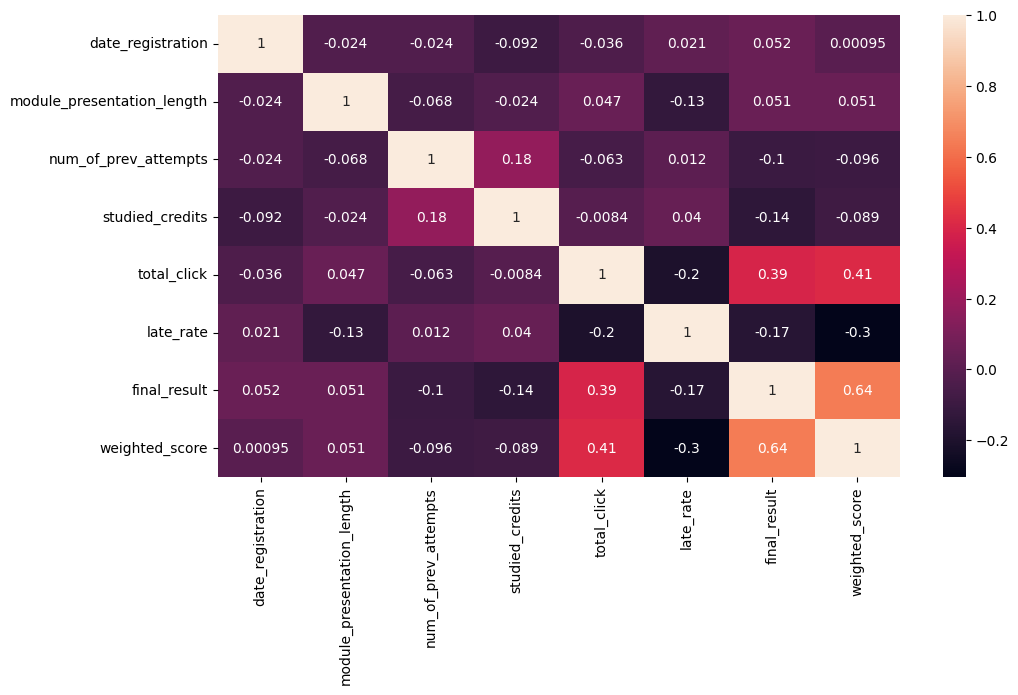

In [ ]:
corr_matrix = Train_plot.corr()
plt.figure(figsize=(11,6))
sns.heatmap(corr_matrix, annot=True)
plt.show()

### Pipeline преобразований

In [ ]:
from sklearn.impute import SimpleImputer # Объект для замены пропущенных значений

from sklearn.preprocessing import OneHotEncoder, MinMaxScaler # Импортируем нормализацию и One-Hot Encoding от scki-kit-learn

from sklearn.pipeline import Pipeline # Pipeline.Не добавить, не убавить

from sklearn.compose import ColumnTransformer # т.н. преобразователь колонок

from sklearn.model_selection import train_test_split #  функция разбиения на тренировочную и тестовую выборку
from sklearn.model_selection import ShuffleSplit # при кросс-валидации случайно перемешиваем данные
from sklearn.model_selection import cross_validate # функция кросс-валидации от Scikit-learn


from sklearn.metrics import mean_squared_error as mse # метрика MSE от Scikit-learn
from sklearn.metrics import r2_score # коэффициент детерминации  от Scikit-learn
from sklearn.metrics import mean_absolute_error as mae # в кач-ве дополнительной метрики возьмем MAE от Scikit-learn

from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV # для поиска при случайном сэмплирование гиперпараметров
from scipy import stats

Создаем объект `Pipeline`

На вход ему подаем список из того, что мы хотим объединить в формате
* строка- название (даем имя Объекту)
* и сам объект (с заданными аргументами, если необходимо)

Сначала создадим отдельно Pipeline для числовых данных (вставление пропусков)

In [ ]:
numerical_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='median'))
])

Предобработка категориальных данных (вставление пропусков + One-Hot кодирование)

In [ ]:
# версия №1 для Catboost
categorical_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent', ))
])

In [ ]:
# версия №2 основная
categorical_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent', )),
    ('encoder', OneHotEncoder(drop='if_binary', handle_unknown='ignore', sparse_output=False))
])

Объект `ColumnTransformer` имеет в целом схожий синтаксис с `Pipeline`

т.е. на вход ему также подаем список из того, что мы хотим объединить в формате

* строка- название (даем имя Объекту)
* сам объект (в этом случае подаем объекты Pipeline)
* добавляется еще список названий столбцов, к которым мы применяем эти преобразования


In [ ]:
preprocessors = ColumnTransformer(transformers=[
    ('num', numerical_pipe, num_columns),
    ('cat', categorical_pipe, cat_columns)
])

"Обучаем" стандартно через `.fit()`

Тут важно, что на вход мы подаем датафреймы, т.к. в них есть колонки к которым мы обращаемся "по именам". Внимательно следите за названиями колонок, он проверяет всё добуквенно

In [ ]:
preprocessors.fit(Train)

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median'))]),
                                 ['date_registration',
                                  'module_presentation_length',
                                  'num_of_prev_attempts', 'studied_credits',
                                  'total_click', 'late_rate']),
                                ('cat',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('encoder',
                                                  OneHotEncoder(drop='if_binary',
                                                                handle_unknown='ignore',
                                                                sparse_output=False))]),
                                 ['code_module', 'code_presentation', 'gender',
                                  'region', 'highest_education', 'imd_band',
                                  'age_band', 'disability'])])

In [ ]:
X_train = preprocessors.transform(Train) # преобразуем  тренировочные данные

In [ ]:
X_test_final = preprocessors.transform(Test) # преобразуем  тестовые данные

In [ ]:
X_train.shape, X_test_final.shape

((26074, 50), (6519, 50))

In [ ]:
X,y = X_train, Train_Target_reg['weighted_score'].values

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

In [ ]:
# Наши метрики для оценки моделей
scoring = {'R2': 'r2',
           '-MSE': 'neg_mean_squared_error',
           '-MAE': 'neg_mean_absolute_error',
           'Max': 'max_error'}

# Тестируем разные модели

## KNN_Reg

In [ ]:
from sklearn.neighbors import KNeighborsRegressor # Регрессия К-Ближайших соседей от scikit-learn

In [ ]:
#@title Гиперпараметры к-Ближайших Соседей{ run: "auto" }
#@markdown ### количество соседей
k = 20 #@param {type:"slider", min:1, max:20, step:1}
#@markdown ### тип весов
weights = 'uniform' #@param [ 'uniform', 'distance']{type:"string"}


# создаем объект класса с указанием гиперпараметров
kNN = KNeighborsRegressor(n_neighbors=k,
                          weights=weights )

# обучаем на тренировочных данных
kNN.fit(X_train, y_train)

# предсказываем на тестовых данных
y_predict=kNN.predict(X_test)

# используем функцию кросс-валидации

scores = cross_validate(kNN, # какую модель тестируем
                        X_train, y_train, # на каких данных
                      scoring=scoring,  #на каких метриках
                      # как разбиваем данные при кросс-валидации
                      cv=ShuffleSplit(n_splits=5, random_state=42))


print('Результаты Кросс-валидации')
DF_cv_kNN = pd.DataFrame(scores)
display(DF_cv_kNN)
print('\n')
print(DF_cv_kNN.mean()[2:])

print('Ошибка на тестовых данных')
print('MSE: %.1f' % mse(y_test,y_predict))
print('RMSE: %.1f' % mse(y_test,y_predict,squared=False))
print('MAE: %.1f' % mae(y_test,y_predict))


print('R2 : %.4f' %  r2_score(y_test,y_predict))

Результаты Кросс-валидации


,fit_time,score_time,test_R2,test_-MSE,test_-MAE,test_Max
0,0.023882,0.795934,0.245162,-656.530999,-21.200941,-75.642875
1,0.023347,0.601259,0.214854,-692.528090,-21.657543,-80.686375
2,0.009106,0.362788,0.253619,-660.503876,-21.242016,-78.522500
3,0.008846,0.371625,0.265600,-660.524497,-21.269933,-80.702458
4,0.009251,0.356848,0.267029,-646.492901,-20.935827,-71.669000




test_R2        0.249253
test_-MSE   -663.316073
test_-MAE    -21.261252
test_Max     -77.444642
dtype: float64
Ошибка на тестовых данных
MSE: 667.9
RMSE: 25.8
MAE: 21.4
R2 : 0.2574


Получили посредственный результат на кросс-валидации, но побили baseline.  
Будем пробовать подобрать оптимальные гиперпараметры

In [ ]:
# словарь гиперпараметров в виде
# обозначение гиперпараметров : из какого распределения сэмплируем
# обозначение должно "досимвольно" совпадать с тем что в документации
parameters = {'n_neighbors':stats.randint(1,50), # задаем распределение как равномерное от 1 до 50
              'weights':['uniform', 'distance']}

# количество итераций
n_iter_search = 20

kNN_search = RandomizedSearchCV(estimator = KNeighborsRegressor(),  # оптимизируем нашу модель
                                verbose = 3,
                          param_distributions=parameters , # что оптимизируем - берем из словарика
                          cv=ShuffleSplit(n_splits=5, random_state=42), # указываем тип кросс-валидации
                          n_iter = n_iter_search # количество итераций
                          )

In [ ]:
kNN_search.fit(X_train, y_train)

kNNbest=kNN_search.best_estimator_

kNNbest.fit(X_train, y_train);

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV 1/5] END ...n_neighbors=36, weights=uniform;, score=0.259 total time=   0.7s
[CV 2/5] END ...n_neighbors=36, weights=uniform;, score=0.239 total time=   0.7s
[CV 3/5] END ...n_neighbors=36, weights=uniform;, score=0.266 total time=   0.8s
[CV 4/5] END ...n_neighbors=36, weights=uniform;, score=0.280 total time=   0.6s
[CV 5/5] END ...n_neighbors=36, weights=uniform;, score=0.271 total time=   0.4s
[CV 1/5] END ...n_neighbors=27, weights=uniform;, score=0.257 total time=   0.4s
[CV 2/5] END ...n_neighbors=27, weights=uniform;, score=0.229 total time=   0.4s
[CV 3/5] END ...n_neighbors=27, weights=uniform;, score=0.263 total time=   0.4s
[CV 4/5] END ...n_neighbors=27, weights=uniform;, score=0.272 total time=   0.4s
[CV 5/5] END ...n_neighbors=27, weights=uniform;, score=0.272 total time=   0.4s
[CV 1/5] END ....n_neighbors=4, weights=uniform;, score=0.123 total time=   0.4s
[CV 2/5] END ....n_neighbors=4, weights=uniform

In [ ]:
y_predict=kNNbest.predict(X_test)

print('Ошибка на тестовых данных')
print('MSE: %.1f' % mse(y_test,y_predict))
print('RMSE: %.1f' % mse(y_test,y_predict,squared=False))
print('MAE: %.1f' % mae(y_test,y_predict))

print('R2 : %.4f' %  r2_score(y_test,y_predict))

Ошибка на тестовых данных
MSE: 650.3
RMSE: 25.5
MAE: 21.3
R2 : 0.2770


In [ ]:
scores = cross_validate(kNNbest, # какую модель тестируем
                        X_train, y_train, # на каких данных
                      scoring=scoring,  #на каких метриках
                      # как разбиваем данные при кросс-валидации
                      cv=ShuffleSplit(n_splits=5, random_state=42))


print('Результаты Кросс-валидации')
DF_cv_kNN = pd.DataFrame(scores)
display(DF_cv_kNN)
print('\n')
print(DF_cv_kNN.mean()[2:])

Результаты Кросс-валидации


,fit_time,score_time,test_R2,test_-MSE,test_-MAE,test_Max
0,0.007329,0.372194,0.257295,-645.978170,-21.149631,-68.944048
1,0.008939,0.400328,0.241935,-668.640971,-21.454229,-76.680595
2,0.026481,0.374783,0.266138,-649.425373,-21.242393,-75.994623
3,0.008975,0.371957,0.279967,-647.602437,-21.223992,-76.526071
4,0.009325,0.392676,0.271444,-642.599239,-21.034417,-72.943810




test_R2        0.263356
test_-MSE   -650.849238
test_-MAE    -21.220933
test_Max     -74.217829
dtype: float64


После подбора гиперпараметров метрики были незначительно улучшены.  
Попробуем другие моедли

## RandomForestRegressor

In [ ]:
from sklearn.ensemble import RandomForestRegressor

RForest = RandomForestRegressor(n_estimators = 17,
 min_samples_split = 5,
 min_samples_leaf = 2,
 max_features = 'auto',
 max_depth = 4,
 bootstrap = False)


RForest.fit(X_train, y_train)

y_predict = RForest.predict(X_test)


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


In [ ]:
# используем функцию кросс-валидации

scores = cross_validate(RForest, # какую модель тестируем
                        X_train, y_train, # на каких данных
                      scoring=scoring,  #на каких метриках
                      # как разбиваем данные при кросс-валидации
                      cv=ShuffleSplit(n_splits=5, random_state=42))


print('Результаты Кросс-валидации')
DF_forest = pd.DataFrame(scores)
display(DF_forest)
print('\n')
print(DF_forest.mean()[2:])

print('Ошибка на тестовых данных')
print('MSE: %.1f' % mse(y_test,y_predict))
print('RMSE: %.1f' % mse(y_test,y_predict,squared=False))
print('MAE: %.1f' % mae(y_test,y_predict))


print('R2 : %.4f' %  r2_score(y_test,y_predict))

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors

Результаты Кросс-валидации


,fit_time,score_time,test_R2,test_-MSE,test_-MAE,test_Max
0,1.331311,0.008334,0.374859,-543.725172,-18.784153,-70.736831
1,1.447402,0.007967,0.381574,-545.474865,-18.740210,-72.826588
2,1.170915,0.006047,0.405888,-525.754799,-18.523058,-73.325026
3,0.930265,0.005795,0.419977,-521.677161,-18.337847,-72.541030
4,0.914052,0.005615,0.385490,-542.009066,-18.761814,-74.184195




test_R2        0.393557
test_-MSE   -535.728213
test_-MAE    -18.629416
test_Max     -72.722734
dtype: float64
Ошибка на тестовых данных
MSE: 541.5
RMSE: 23.3
MAE: 18.8
R2 : 0.3980


In [ ]:
# Создадим словарь с значениями гиперпараметров для RFR
n_estimators = [int(x) for x in np.linspace(start = 10, stop = 80, num = 10)]

max_features = ['auto', 'sqrt']

max_depth = [4,8,12,16,20]

min_samples_split = [4, 8, 12, 16, 20]

min_samples_leaf = [2, 4, 8, 12, 16, 20]

bootstrap = [True, False]

param_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [ ]:
rf_RandomGrid = RandomizedSearchCV(estimator = RForest, param_distributions = param_grid, cv = 10, verbose=2, n_jobs = 4)

In [ ]:
rf_RandomGrid.fit(X_train, y_train)

Fitting 10 folds for each of 10 candidates, totalling 100 fits


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


RandomizedSearchCV(cv=10,
                   estimator=RandomForestRegressor(bootstrap=False, max_depth=4,
                                                   max_features='auto',
                                                   min_samples_leaf=2,
                                                   min_samples_split=5,
                                                   n_estimators=17),
                   n_jobs=4,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [4, 8, 12, 16, 20],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [2, 4, 8, 12, 16,
                                                             20],
                                        'min_samples_split': [4, 8, 12, 16, 20],
                                        'n_estimators': [10, 17, 25, 33, 41, 48,
                                                         56, 64, 72, 80]},
                   verbose=2)

In [ ]:
params=rf_RandomGrid.best_params_
params

{'n_estimators': 64,
 'min_samples_split': 12,
 'min_samples_leaf': 20,
 'max_features': 'auto',
 'max_depth': 20,
 'bootstrap': True}

In [ ]:
RForest_best = RandomForestRegressor(n_estimators = 64,
 min_samples_split = 12,
 min_samples_leaf = 20,
 max_features = 'auto',
 max_depth = 20,
 bootstrap = True)


RForest_best.fit(X_train, y_train)

y_predict = RForest_best.predict(X_test)

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


In [ ]:
cross_validation (X_train, y_train,
                  RForest_best, scoring,
                  ShuffleSplit(n_splits=5, random_state=42))

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors

Ошибка на кросс-валидации


,fit_time,score_time,test_R2,test_-MSE,test_-MAE,test_Max
0,5.361666,0.029788,0.574690,-369.919647,-14.758757,-72.184854
1,6.035239,0.041778,0.543635,-402.530459,-15.113117,-79.676201
2,5.826684,0.030269,0.578197,-373.270789,-14.746366,-74.323795
3,5.434990,0.030354,0.587792,-370.742573,-14.680659,-76.708984
4,6.565271,0.030258,0.557498,-390.294940,-15.060164,-83.914279




test_R2        0.568363
test_-MSE   -381.351681
test_-MAE    -14.871813
test_Max     -77.361623
dtype: float64


Получаем значительное улучшение по сравнению с KNN

In [ ]:
features_names_reg = Train.columns
features_names_reg

Index(['code_module', 'code_presentation', 'date_registration',
       'module_presentation_length', 'gender', 'region', 'highest_education',
       'imd_band', 'age_band', 'num_of_prev_attempts', 'studied_credits',
       'disability', 'total_click', 'late_rate'],
      dtype='object')

In [ ]:
x_col = X_train.copy()
x_col = pd.DataFrame(x_col)
features_names_reg = x_col.columns

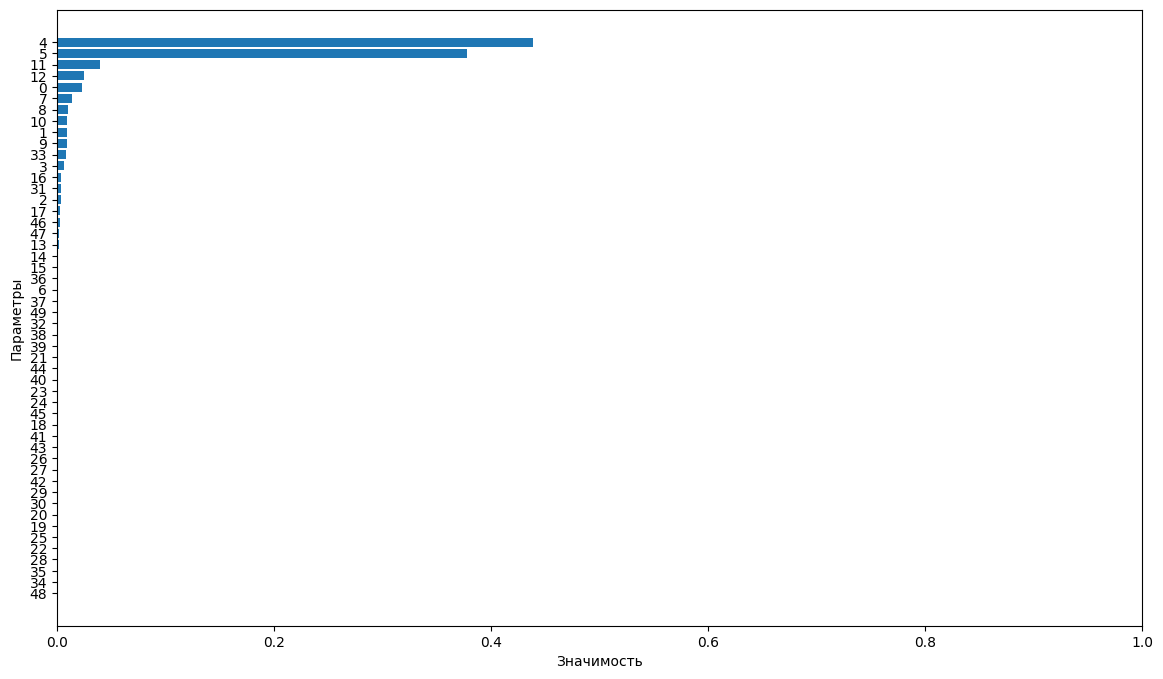

In [ ]:
feature_importance_plotter(RForest_best, features_names_reg)

Наибольший прирост дали признаки total_click, late_rate и судя по всему   imd_band и age_band (после OHE) + весомым для модели оказался date_registration


In [ ]:
Train

,code_module,code_presentation,date_registration,module_presentation_length,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,total_click,late_rate
ID,,,,,,,,,,,,,,
0,DDD,2014B,-36.0,241,F,East Anglian Region,A Level or Equivalent,50-60%,0-35,1,70,N,1694.0,0.142857
1,DDD,2013J,-32.0,261,M,Scotland,A Level or Equivalent,20-30%,0-35,0,120,N,692.0,0.000000
2,CCC,2014J,-21.0,269,M,South Region,HE Qualification,70-80%,55<=,0,60,N,1963.0,0.750000
3,FFF,2014J,-124.0,269,M,West Midlands Region,Lower Than A Level,10-20,0-35,0,60,N,2138.0,0.181818
4,FFF,2013J,-114.0,268,M,South East Region,Lower Than A Level,10-20,35-55,0,60,N,188.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26069,AAA,2014J,-141.0,269,M,Yorkshire Region,HE Qualification,20-30%,0-35,0,60,N,5183.0,0.000000
26070,BBB,2014J,-64.0,262,F,North Western Region,HE Qualification,30-40%,35-55,0,120,N,42.0,0.000000
26071,BBB,2013B,-124.0,240,F,West Midlands Region,Lower Than A Level,0-10%,0-35,2,60,Y,25.0,1.000000


## AdaBoost

In [ ]:
from sklearn.ensemble import AdaBoostRegressor

In [ ]:
#@title ### **Настройка гиперпараметров:** { run: "auto" }
n_estimators=80 #@param {type:"slider", min:10, max:200, step:10}
learning_rate=1 #@param {type:"slider", min:0.00, max:1, step:0.05}


ABR = AdaBoostRegressor(learning_rate=learning_rate,
                        n_estimators=n_estimators,
                         )


ABR.fit(X_train, y_train)

y_predict=ABR.predict(X_test)

Метрики на уровне KNN

In [ ]:
cross_validation (X_train, y_train,
                  ABR, scoring,
                  ShuffleSplit(n_splits=5, random_state=42))

Ошибка на кросс-валидации


,fit_time,score_time,test_R2,test_-MSE,test_-MAE,test_Max
0,1.452615,0.010826,0.362724,-554.279929,-19.987527,-62.417195
1,1.400059,0.010897,0.362117,-562.636122,-20.127758,-67.809957
2,1.099287,0.009016,0.372459,-555.337263,-20.158748,-56.330775
3,0.810062,0.006889,0.387448,-550.933931,-19.881703,-68.624807
4,1.573292,0.017919,0.359590,-564.853077,-20.354358,-61.350747




test_R2        0.368868
test_-MSE   -557.608064
test_-MAE    -20.102019
test_Max     -63.306696
dtype: float64


Подберем оптимальные геперпараметры

In [ ]:
parameters = {
    'n_estimators': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 20],
    'learning_rate': [(0.97 + x / 100) for x in range(0, 8)],
}

In [ ]:
adaboost_rand_search = RandomizedSearchCV(estimator = ABR, param_distributions = parameters, cv = 10, verbose=2, n_jobs = 4)
adaboost_rand_search.fit(X_train, y_train)

Fitting 10 folds for each of 10 candidates, totalling 100 fits


RandomizedSearchCV(cv=10,
                   estimator=AdaBoostRegressor(learning_rate=1,
                                               n_estimators=80),
                   n_jobs=4,
                   param_distributions={'learning_rate': [0.97, 0.98, 0.99, 1.0,
                                                          1.01, 1.02, 1.03,
                                                          1.04],
                                        'n_estimators': [2, 3, 4, 5, 6, 7, 8, 9,
                                                         10, 11, 12, 20]},
                   verbose=2)

In [ ]:
adaboost_rand_search.best_estimator_

AdaBoostRegressor(learning_rate=0.97, n_estimators=7)

In [ ]:
ABR = AdaBoostRegressor(learning_rate=0.97,
                        n_estimators=7,
                         )


ABR.fit(X_train, y_train)

y_predict=ABR.predict(X_test)

Получаем незначительное улучшение метрик

In [ ]:
cross_validation (X_train, y_train,
                  ABR, scoring,
                  ShuffleSplit(n_splits=5, random_state=42))

Ошибка на кросс-валидации


,fit_time,score_time,test_R2,test_-MSE,test_-MAE,test_Max
0,0.407173,0.004830,0.355175,-560.845768,-19.673404,-66.670313
1,0.411220,0.004931,0.374396,-551.805891,-19.497015,-72.215151
2,0.519120,0.008656,0.390106,-539.720519,-19.447287,-66.414799
3,0.584340,0.006784,0.390128,-548.523062,-19.636419,-69.650027
4,0.588736,0.006861,0.377028,-549.472072,-19.508525,-68.337535




test_R2        0.377367
test_-MSE   -550.073462
test_-MAE    -19.552530
test_Max     -68.657565
dtype: float64


## XGBoost

In [ ]:
import xgboost as xg

In [ ]:
model_reg = xg.XGBRegressor(random_state = 42,
                            objective= 'reg:squarederror',
                        learning_rate=0.01,
                        n_estimators=500)
model_reg.fit(X_train,y_train,
          eval_set=[(X_train, y_train), (X_test, y_test)]);

y_predict=model_reg.predict(X_test)

[0]	validation_0-rmse:59.32435	validation_1-rmse:59.77100
[1]	validation_0-rmse:58.80777	validation_1-rmse:59.25439
[2]	validation_0-rmse:58.29699	validation_1-rmse:58.74438
[3]	validation_0-rmse:57.79196	validation_1-rmse:58.23897
[4]	validation_0-rmse:57.29248	validation_1-rmse:57.74034
[5]	validation_0-rmse:56.79577	validation_1-rmse:57.24481
[6]	validation_0-rmse:56.30725	validation_1-rmse:56.75714
[7]	validation_0-rmse:55.82162	validation_1-rmse:56.27263
[8]	validation_0-rmse:55.34427	validation_1-rmse:55.79544
[9]	validation_0-rmse:54.87238	validation_1-rmse:55.32425
[10]	validation_0-rmse:54.40582	validation_1-rmse:54.85820
[11]	validation_0-rmse:53.94425	validation_1-rmse:54.39776
[12]	validation_0-rmse:53.48827	validation_1-rmse:53.94204
[13]	validation_0-rmse:53.03751	validation_1-rmse:53.49178
[14]	validation_0-rmse:52.59182	validation_1-rmse:53.04650
[15]	validation_0-rmse:52.15097	validation_1-rmse:52.60625
[16]	validation_0-rmse:51.71561	validation_1-rmse:52.17110
[17]	va

In [ ]:
cross_validation (X_train, y_train,
                  model_reg, scoring,
                  ShuffleSplit(n_splits=5, random_state=42))

Ошибка на кросс-валидации


,fit_time,score_time,test_R2,test_-MSE,test_-MAE,test_Max
0,29.639589,0.031052,0.560925,-381.891647,-15.321883,-73.608556
1,31.544199,0.083695,0.542470,-403.558577,-15.576455,-74.914207
2,30.206576,0.030156,0.570040,-380.489411,-15.218813,-70.033640
3,29.860946,0.028896,0.578276,-379.301190,-15.186706,-76.278913
4,31.926499,0.049689,0.548072,-398.608649,-15.579372,-76.096485




test_R2        0.559957
test_-MSE   -388.769895
test_-MAE    -15.376646
test_Max     -74.186360
dtype: float64


Сходу получаем метрики сопоставимые с показателями RandomForest.  
Пробуем менять гиперпараметры

In [ ]:
param_tuning = {
        'learning_rate': [0.01, 0.1],
        'max_depth': [3, 5, 7, 10],
        'min_child_weight': [1, 3, 5],
        'subsample': [0.5, 0.7],
        'colsample_bytree': [0.5, 0.7],
        'n_estimators' : [100, 200, 500],
        'objective': ['reg:squarederror']}

In [ ]:
xgsearch = RandomizedSearchCV(estimator = model_reg, param_distributions = param_tuning, cv = 10, verbose=2, n_jobs = 4)
xgsearch.fit(X_train, y_train)

Fitting 10 folds for each of 10 candidates, totalling 100 fits


RandomizedSearchCV(cv=10,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          gamma=None, gpu_id=None,
                                          grow_policy=None,
                                          importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate...
                                          min_child_weight=None, missing=nan,
                                          monotone_constraints=None,
                                          n_estimators=500, n_jobs=None,
                                          num_parallel_tree=None,
                                          predictor=None, random_state=42, ...),
                   n_jobs=4,
                   param_distributions={'colsample_bytree': [0.5, 0.7],
                                        'learning_rate': [0.01, 0.1],
                                        'max_depth': [3, 5, 7, 10],
                                        'min_child_weight': [1, 3, 5],
                                        'n_estimators': [100, 200, 500],
                                        'objective': ['reg:squarederror'],
                                        'subsample': [0.5, 0.7]},
                   verbose=2)

In [ ]:
xg_best = xgsearch.best_estimator_

In [ ]:
xg_best.fit(X_train,y_train,
          eval_set=[(X_train, y_train), (X_test, y_test)]);

y_predict=xg_best.predict(X_test)

[0]	validation_0-rmse:54.72567	validation_1-rmse:55.15858
[1]	validation_0-rmse:50.31373	validation_1-rmse:50.76166
[2]	validation_0-rmse:46.23601	validation_1-rmse:46.68464
[3]	validation_0-rmse:42.65458	validation_1-rmse:43.11140
[4]	validation_0-rmse:39.49601	validation_1-rmse:39.98416
[5]	validation_0-rmse:36.83184	validation_1-rmse:37.32917
[6]	validation_0-rmse:34.44192	validation_1-rmse:34.93858
[7]	validation_0-rmse:32.39853	validation_1-rmse:32.89607
[8]	validation_0-rmse:30.54646	validation_1-rmse:31.05465
[9]	validation_0-rmse:28.98987	validation_1-rmse:29.49202
[10]	validation_0-rmse:27.67763	validation_1-rmse:28.20511
[11]	validation_0-rmse:26.57948	validation_1-rmse:27.10437
[12]	validation_0-rmse:25.56881	validation_1-rmse:26.08445
[13]	validation_0-rmse:24.74826	validation_1-rmse:25.25417
[14]	validation_0-rmse:23.99506	validation_1-rmse:24.49596
[15]	validation_0-rmse:23.37200	validation_1-rmse:23.85393
[16]	validation_0-rmse:22.83086	validation_1-rmse:23.30872
[17]	va

In [ ]:
cross_validation (X_train, y_train,
                  xg_best, scoring,
                  ShuffleSplit(n_splits=5, random_state=42))

Ошибка на кросс-валидации


,fit_time,score_time,test_R2,test_-MSE,test_-MAE,test_Max
0,9.486138,0.013247,0.569767,-374.201482,-15.010228,-80.249800
1,9.465944,0.012992,0.541764,-404.181061,-15.379847,-74.527077
2,6.921425,0.011898,0.580580,-371.162454,-14.816390,-70.711416
3,9.462402,0.013072,0.588652,-369.969479,-14.778830,-74.109319
4,9.382614,0.011897,0.560695,-387.474905,-15.222780,-74.894087




test_R2        0.568291
test_-MSE   -381.397876
test_-MAE    -15.041615
test_Max     -74.898340
dtype: float64


Получившиеся метрки на одном уровне с показателями RF

In [ ]:
y_predict_test = xg_best.predict(X_test_final)

In [ ]:
Submission['weighted_score'] = y_predict_test

# Оценка моделей

Оценки моделей по MSE на валидационной выборке:

KNN_Reg - 650.849238  
RandomForest_Reg - 381.351681  
AdaBoost = 550.073462  
XGBoost - 381.397876  

Наилучшего результата на проверочных данных с Kaggle удалось добиться с xgboost

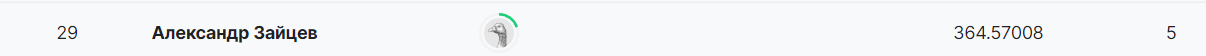

# Загружаем модель

Пробуем загрузить файл загрузки с базовой моделью


In [ ]:
Submission.to_csv('/content/xg_Submission.csv',index=True)

In [ ]:
#                                ↓ соревнование         ↓ название файла     ↓ комментарий
!kaggle competitions submit -c urfuaieng2022reg2 -f RIDGE_Submission.csv -m "ridge regression test"

100% 154k/154k [00:00<00:00, 325kB/s]
Successfully submitted to UrFU_AI_Eng_2022_Reg_2